# Image Generation with a non-1:1 Aspect Ratio

### Table of Contents
1. [DM-only Generation using a latent image of shape (512, 512)](#1.-dm-only-Generation-using-a-latent-image-of-shape-(512,-512))
2. [DM-only Generation using a latent image of shape (940, 564)](#2.-dm-only-Generation-using-a-latent-image-of-shape-(940,-564))
3. [Takeaways](#Takeaways)

Here, the task was to check whether we can generate images of different aspect ratios using SD and to compare the generation quality with the 1:1 depth-map. For this task, I used the depth-only ControlNet workflow with `2_nocrop_G.png` [(940, 564) or 16:9]. The steps taken were as follows:
1. Generate using a latent image of shape (512, 512) (default shape).
2. Generate using a latent image of shape (940, 564).

Note that, no up/down-scaling was done for this task.

<center>
    <h4>Aspect Ratio: ComfyUI Workflow (added to the DM-only-ControlNet workflow)</h4>
    <img src="./workflows/2_aspect_ratio/2_aspect_ratio_workflow.png" width="80%" alt="Aspect Ratio: ComfyUI Workflow">
</center>

The associated ComfyUI workflow is available [here](./workflows/2_aspect_ratio/2_aspect_ratio_workflow.json) (`./workflows/2_aspect_ratio/2_aspect_ratio_workflow.json`). The results are presented below.

In [1]:
import json
import numpy as np
from rich import print
from rich.table import Table
from pathlib import Path
from matplotlib import pyplot as plt
from PIL import Image

# Local imports
from utils import create_table

# `create_table` is a function that creates a table of metrics and saves them to a .json file

exp_root = Path("./results/2_aspect_ratio")

## 1. DM-only Generation using a latent image of shape (512, 512)

As (512, 512) is the default shape for SD1.5, I was interested in checking the quality of the generated image using this default shape. The expectation was that the image would be either be center-cropped or squeezed to fit the aspect ratio of the latent image. Based on the results below, it is clear that the outputs were center-cropped.

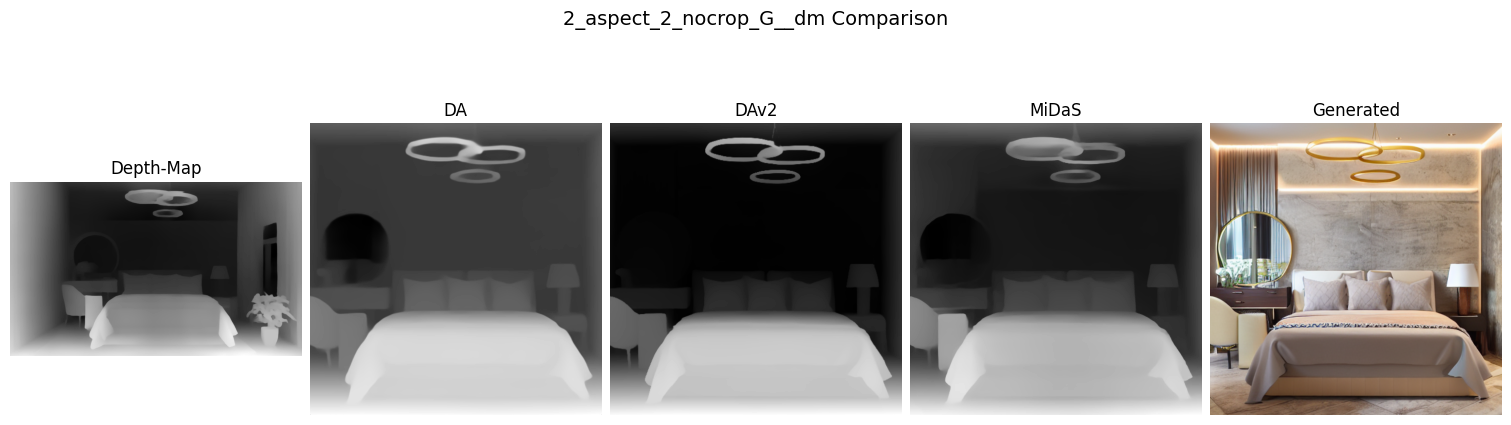

/home/js/miniconda3/envs/comfyenv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905971214/work/aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


                 Quantitative Metrics                  
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric  ┃          2_aspect_2_nocrop_G__dm          ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ DepthAnything ┃ DepthAnything v2 ┃ MiDaS  │
│━━━━━━━━━│━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━│
│ NRMSE ↓ │     0.511     │      0.584       │ 0.474  │
│ SSIM ↑  │     0.659     │      0.426       │ 0.695  │
│ PSNR ↑  │    13.035     │      11.875      │ 13.689 │
│MANIQA ↑ │                   0.641                   │
└─────────┴───────────────────────────────────────────┘

In [2]:
# Visualizing results
exp_name = "1-to-1"
exp_path = exp_root / exp_name
save_path = exp_path / "results"
save_path.mkdir(exist_ok=True)

res = list(exp_path.glob(f"*.png"))
res.sort()

da, dav2, dm, gen, midas = res
dm_stem = dm.stem

dm_img = Image.open(dm).convert("L")
da_img = Image.open(da).convert("L")
dav2_img = Image.open(dav2).convert("L")
midas_img = Image.open(midas).convert("L")
gen_img = Image.open(gen)

# Plot images
fig, axs = plt.subplots(1, 5, figsize=(15, 5), constrained_layout=True)
fig.suptitle(f"{dm_stem} Comparison", fontsize=14)

axs[0].imshow(dm_img, cmap="gray")
axs[0].set_title("Depth-Map")
axs[0].axis("off")

axs[1].imshow(da_img, cmap="gray")
axs[1].set_title("DA")
axs[1].axis("off")

axs[2].imshow(dav2_img, cmap="gray")
axs[2].set_title("DAv2")
axs[2].axis("off")

axs[3].imshow(midas_img, cmap="gray")
axs[3].set_title("MiDaS")
axs[3].axis("off")

axs[4].imshow(gen_img)
axs[4].set_title("Generated")
axs[4].axis("off")

# Save image to file
plt.savefig(save_path / f"{dm_stem}_comparison.png", bbox_inches="tight")
plt.show()

# Resize base DM to 1:1 for comparison (NOTE: The workflow also resizes the generated image using the same method)
dm_img = dm_img.resize((gen_img.size[0], gen_img.size[1]), Image.NEAREST)

# Create table & save results to json
met_table = create_table(
    dm_img,
    [da_img, dav2_img, midas_img],
    gen_img,
    dm_stem,
    json_path=save_path / f"{dm_stem}_metrics.json",
)

print(met_table)

## 2. DM-only Generation using a latent image of shape (940, 564)

A quick check revealed that despite matching the latent size, the output could not match the exact input size and therefore, the desired aspect ratio. I added a simple fix here, which was to upscale the output image to the desired size. The results are presented below. 

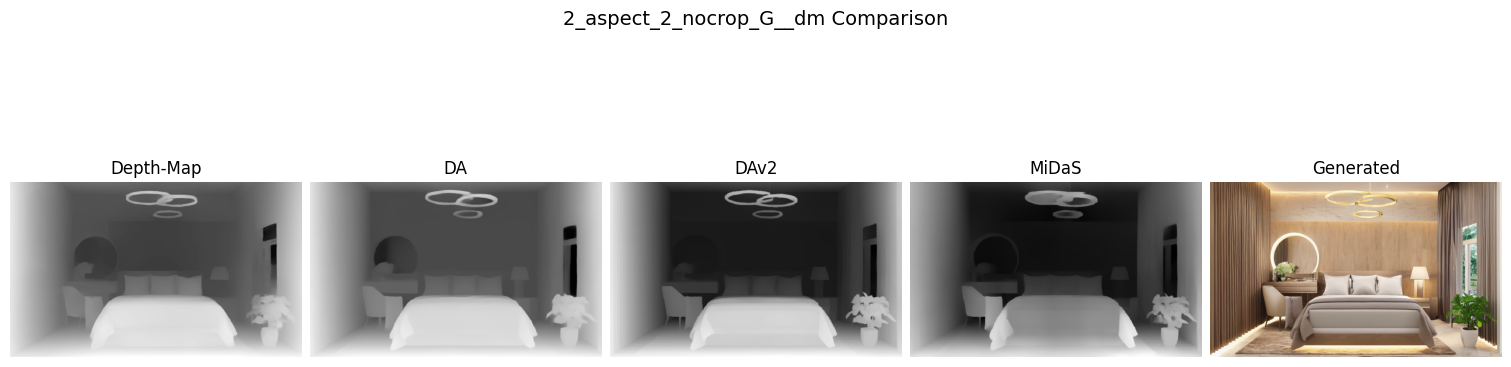

                 Quantitative Metrics                  
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric  ┃          2_aspect_2_nocrop_G__dm          ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ DepthAnything ┃ DepthAnything v2 ┃ MiDaS  │
│━━━━━━━━━│━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━│
│ NRMSE ↓ │     0.076     │      0.248       │ 0.344  │
│ SSIM ↑  │     0.953     │      0.807       │ 0.741  │
│ PSNR ↑  │    26.939     │      16.723      │ 13.878 │
│MANIQA ↑ │                   0.659                   │
└─────────┴───────────────────────────────────────────┘

In [3]:
# Visualizing results
exp_name = "16-to-9"
exp_path = exp_root / exp_name
save_path = exp_path / "results"
save_path.mkdir(exist_ok=True)

res = list(exp_path.glob(f"*.png"))
res.sort()

da, dav2, dm, gen, midas = res
dm_stem = dm.stem

dm_img = Image.open(dm).convert("L")
da_img = Image.open(da).convert("L")
dav2_img = Image.open(dav2).convert("L")
midas_img = Image.open(midas).convert("L")
gen_img = Image.open(gen)

# Plot images
fig, axs = plt.subplots(1, 5, figsize=(15, 5), constrained_layout=True)
fig.suptitle(f"{dm_stem} Comparison", fontsize=14)

axs[0].imshow(dm_img, cmap="gray")
axs[0].set_title("Depth-Map")
axs[0].axis("off")

axs[1].imshow(da_img, cmap="gray")
axs[1].set_title("DA")
axs[1].axis("off")

axs[2].imshow(dav2_img, cmap="gray")
axs[2].set_title("DAv2")
axs[2].axis("off")

axs[3].imshow(midas_img, cmap="gray")
axs[3].set_title("MiDaS")
axs[3].axis("off")

axs[4].imshow(gen_img)
axs[4].set_title("Generated")
axs[4].axis("off")

# Save image to file
plt.savefig(save_path / f"{dm_stem}_comparison.png", bbox_inches="tight")
plt.show()

# Resize base DM to 1:1 for comparison (NOTE: The workflow also resizes the generated image using the same method)
# dm_img = dm_img.resize((gen_img.size[0], gen_img.size[1]), Image.NEAREST)

# Create table & save results to json
met_table = create_table(
    dm_img,
    [da_img, dav2_img, midas_img],
    gen_img,
    dm_stem,
    json_path=save_path / f"{dm_stem}_metrics.json",
)

print(met_table)

## Takeaways
* The answer to the primary question is yes, but with upscaling.
* As for the generation quality, it is evident from the tables above, that the quality is at least on par, if not slightly better, as compared to 1:1, with the same depth-control. Adding more controls (specifically, tiling) could further improve the quality.